In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

%matplotlib inline

2024-02-16 15:16:54.024939: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 15:16:55.060854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 15:16:55.060874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 15:16:55.066578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 15:16:55.609456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 15:16:55.610901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed.csv", sep=",", usecols=range(1,23), skiprows=[0])

In [3]:
# attacks = preprocessing.normalize(attacks.to_numpy(), norm="max", axis=0)
attacks = attacks.to_numpy()

# swap sport to front
attacks[:, [0, 1]] = attacks[:, [1, 0]]
# swap dport to after sport
attacks[:, [1, 2]] = attacks[:, [2, 1]]
# swap protocols to after dport
attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)



# should probably add batch and shuffle

train_dataset = attacks[:int(np.floor(attacks.shape[0]*3/4))]
test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]

num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
seq_length = 5

In [4]:
len(train_dataset), len(test_dataset)

(1993625, 664542)

In [5]:
# custom loss
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

In [6]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [40]:
# noise will have same dimension as one flow

def make_generator_model(input_dim):
    """
    The generator takes noise as input and goes through a couple
    of hidden layers. Then, it splits the output into 3 softmax layers
    (one for each categorical variable with the same dimension as the 
    number of possible values that variable can take) and a dense
    layer for all the rest of the continuous variables.

    Bigger node size in the initial dense layer decreases critic loss substantially.

    Adding sigmoid acativation to continuous output layer drops generator loss
    (probably also really need this so it doesn't predict negative values).
    """
    input = tf.keras.layers.Input(shape=input_dim, name="generator input")

    hidden = tf.keras.layers.Dense(1000, name="generator_dense_1")(input)

    hidden = tf.keras.layers.Dense(5000, name="generator_dense_2")(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.LeakyReLU(0.2)(hidden)

    hidden = tf.keras.layers.Dense(10000, name="generator_input_3")(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.LeakyReLU(0.2)(hidden)

    sport_hidden = tf.keras.layers.Dense(23030, name="sport_hidden")(hidden)
    sport_hidden = tf.keras.layers.BatchNormalization()(sport_hidden)
    sport_hidden = tf.keras.layers.LeakyReLU(0.2)(sport_hidden)

    dport_hidden = tf.keras.layers.Dense(14372, name="dport_hidden")(hidden)
    dport_hidden = tf.keras.layers.BatchNormalization()(dport_hidden)
    dport_hidden = tf.keras.layers.LeakyReLU(0.2)(dport_hidden)

    proto_hidden = tf.keras.layers.Dense(7, name="proto_hidden")(hidden)
    proto_hidden = tf.keras.layers.BatchNormalization()(proto_hidden)
    proto_hidden = tf.keras.layers.LeakyReLU(0.2)(proto_hidden)

    # dense output for continuous, softmax for categorical
    sport_output = tf.keras.layers.Softmax(1, name="sport_output")(sport_hidden)
    dport_output = tf.keras.layers.Softmax(1, name="dport_output")(dport_hidden)
    proto_output = tf.keras.layers.Softmax(1, name="proto_output")(proto_hidden)
    cont_output = tf.keras.layers.Dense(num_features-3, name="cont_output", activation="tanh")(hidden)

    model = tf.keras.Model(inputs=input, outputs=[sport_output, dport_output, proto_output, cont_output], 
                           name="Generator")
    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

In [8]:
def convert_generator_output(arr):
    """
    For each categorical feature, takes the most likely probability given
    by the Softmax output and concatenates it with the continuous features.
    This is so the generated data has the same shape as the real data.
    """
    sport_dist, dport_dist, proto_dist, cont = arr
    num_samples = sport_dist.shape[0]
    final = np.zeros(22)
    for sample_index in range(num_samples):
        sport = np.array([np.argmax(sport_dist[sample_index])+1])
        dport = np.array([np.argmax(dport_dist[sample_index])+1])
        proto = np.array([np.argmax(proto_dist[sample_index])+1])
        data_point = np.concatenate((sport, dport, proto, cont[sample_index]))
        final = np.vstack((final, data_point))
    return tf.convert_to_tensor(final[1:])

In [9]:
def convert_generator_output_tensor(tens):
    sport_dist, dport_dist, proto_dist, cont = tens
    sport_dist = sport_dist.numpy()
    dport_dist = dport_dist.numpy()
    proto_dist = proto_dist.numpy()
    cont = cont.numpy()
    # num_samples = 5
    # print(tf.shape(sport_dist))
    # final = tf.zeros(num_features,)
    # for sample_index in range(num_samples):
    #     sport_val = tf.constant(tf.argmax(sport_dist[sample_index]).numpy(), dtype=tf.float32)
    #     dport_val = tf.constant(tf.argmax(dport_dist[sample_index]).numpy(), dtype=tf.float32)
    #     proto_val = tf.constant(tf.argmax(proto_dist[sample_index]).numpy(), dtype=tf.float32)
    #     disc = tf.stack([sport_val, dport_val, proto_val], 0)
    #     data_point = tf.concat([disc, cont[sample_index]], 0)
    #     final = tf.stack([final, data_point], 1)
    # print(final)
    num_samples = sport_dist.shape[0]
    final = np.zeros(22)
    for sample_index in range(num_samples):
        sport = np.array([np.argmax(sport_dist[sample_index])+1])
        dport = np.array([np.argmax(dport_dist[sample_index])+1])
        proto = np.array([np.argmax(proto_dist[sample_index])+1])
        data_point = np.concatenate((sport, dport, proto, cont[sample_index]))
        final = np.vstack((final, data_point))
    return tf.convert_to_tensor(final[1:])

In [10]:
# generator = make_generator_model(50)
# noise = generate_latent_points(50, 5)
# X_fake = generator(noise, training=False)


In [11]:
# type(convert_generator_output(X_fake))

In [12]:
def make_critic_model(input_shape):
    """
    Critic (discriminator) more or less as described by the WGAN people.
    The output layer uses linear activation since this is a critic and not 
    a standard discriminator.
    """
    const = ClipConstraint(0.01)

    input = tf.keras.layers.Input(shape=input_shape, name="discriminator input")
    hidden = tf.keras.layers.LSTM(100, recurrent_dropout=0.4, return_sequences=True, kernel_constraint=const)(input)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.LSTM(100, recurrent_dropout=0.4, kernel_constraint=const)(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    output = tf.keras.layers.Dense(1, activation="linear")(hidden)

    model = tf.keras.Model(inputs=input, outputs=output, name="Critic")

    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=wasserstein_loss, optimizer=opt)

    return model

In [13]:
def make_gan(generator, critic, gen_input_dim):
    """
    Would be a convenient way to train the GAN but this doesn't work
    because the generator output has 4 tensors (one for each layer)
    and the critic expects an input with the same dimension as the real data.

    We can't just change the shape of the real data because I'd have to one-hot encode
    the categorical variables - these datasets are huge and it would take FOREVER.
    """
    for layer in critic.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    input = tf.keras.layers.Input(shape=gen_input_dim, name="combined input")
    x = generator(input)
    x = critic(x)
    model = tf.keras.Model(inputs=input, outputs=x)
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [14]:
# Some helper functions that may or may not be useful

def generate_latent_points(latent_dim, n_samples):
	"""
	Generate points in latent space as input for the generator.
	"""
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_real_samples(dataset, n_samples):
	"""
	Select real samples.
	"""
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# select data
	X = dataset[ix]
	# refactor real data to have same shape as generated data (4 tensors)
	
	# generate class labels, -1 for 'real'
	y = -np.ones((n_samples, 1))
	return X, y

def generate_fake_samples(generator, latent_dim, n_samples):
	"""
	Use the generator to generate n fake examples, with class labels
	"""

	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	X = convert_generator_output(X)
	# create class labels with 1.0 for 'fake'
	y = np.ones((n_samples, 1))
	return X, y

In [52]:
# Wasserstein loss for critic
def critic_loss(pred_real, pred_fake):
    # return tf.keras.backend.mean(pred_real * pred_fake)
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for generator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(pred_fake):
    return -tf.keras.backend.mean(pred_fake)
    # return cross_entropy(tf.ones_like(pred_fake), pred_fake)

In [62]:
generator_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
critic_optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

In [63]:
def train_step(generator, critic, dataset, latent_dim, n_batch=64, n_critic=5):

    for _ in range(n_critic):

        """
        Train critic more often than the generator for WGAN
        """

        with tf.GradientTape() as critic_tape:
            # Critic training works fine
            X_real, y_real = generate_real_samples(dataset, n_batch)
            noise = generate_latent_points(latent_dim, n_batch)
            X_fake = generator(noise, training=True)
            X_fake = convert_generator_output(X_fake)

            pred_real = critic(X_real, training=True)
            pred_fake = critic(X_fake, training=True)

            c_loss = critic_loss(pred_real, pred_fake)
        

        critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
        critic_optimiser.apply_gradients(zip(critic_gradients, critic.trainable_variables))
    print(f"Critic loss: {c_loss}")  
    """ 
    Train generator
    """

    with tf.GradientTape() as gen_tape:
        X_fake = generator(noise, training=True)
        X_fake = convert_generator_output(X_fake)
        pred_fake = critic(X_fake, training=False)
        g_loss = generator_loss(pred_fake)
        print(f"Generator loss: {g_loss}")
    
    # These gradients are all None and I can't figure out why
    # Are the multiple output layers of the generator a problem here?
    # Maybe the definition of the loss function?
    generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    # generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))


    return c_loss, g_loss

In [64]:
def train(dataset, n_epochs=2, latent_dim=50):

    generator = make_generator_model(latent_dim)
    critic = make_critic_model((num_features, 1))

    c_losses, g_losses = [], []

    for i in range(n_epochs):
        print(f"Epoch: {i+1}")
        for batch in dataset:
            c_loss, g_loss = train_step(generator, critic, batch, latent_dim)
            c_losses.append(c_loss)
            g_losses.append(g_loss)

    return c_losses, g_losses

In [65]:
# Test training on a small sample of the dataset
dataset = np.array_split(attacks[:5000], 10)
# dataset = (tf.data.Dataset.from_tensor_slices(attacks[:1000]).shuffle(10000).batch(64))
c_losses, g_losses = train(dataset, 2, 10)

Epoch: 1
Critic loss: 5.960464477539063e-08
Generator loss: 0.008305775001645088
Critic loss: 2.682209014892578e-07
Generator loss: 0.015814177691936493
Critic loss: -1.1175870895385742e-07
Generator loss: 0.021025950089097023
Critic loss: 4.842877388000488e-08
Generator loss: 0.024651803076267242
Critic loss: 2.0116567611694336e-07
Generator loss: 0.030883759260177612
Critic loss: -2.2351741790771484e-08
Generator loss: 0.03645201399922371
Critic loss: -1.2665987014770508e-07
Generator loss: 0.0397157296538353
Critic loss: -2.2351741790771484e-08
Generator loss: 0.04340490326285362
Critic loss: -1.4901161193847656e-08
Generator loss: 0.049316175282001495
Critic loss: -1.4901161193847656e-08
Generator loss: 0.05171509087085724
Epoch: 2
Critic loss: -5.960464477539063e-08
Generator loss: 0.05397547036409378
Critic loss: -4.470348358154297e-08
Generator loss: 0.05959901586174965
Critic loss: 5.21540641784668e-08
Generator loss: 0.06110450625419617
Critic loss: 1.7136335372924805e-07
Gene

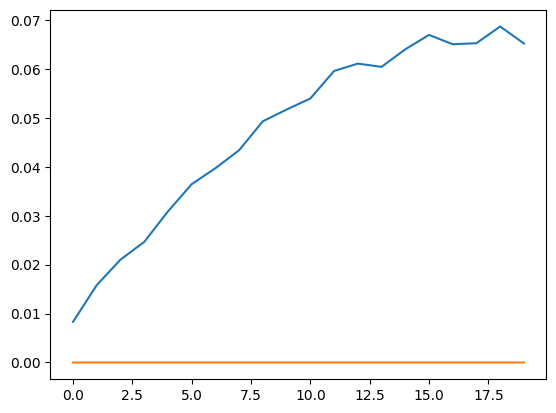

In [66]:
plt.plot(g_losses)
plt.plot(c_losses)

In [19]:
import typing


class WGAN(tf.keras.models.Model):
    def __init__(
            self,
            critic: tf.keras.models.Model,
            generator: tf.keras.models.Model,
            latent_dim: int,
            critic_extra_steps: int=5,
    ) -> None:
        super(WGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_extra_steps = critic_extra_steps

    def compile(
            self,
            critic_optimiser: tf.keras.optimizers.Optimizer,
            generator_optimiser: tf.keras.optimizers.Optimizer,
            critic_loss: typing.Callable,
            generator_loss: typing.Callable,
            **kwargs
    ) -> None:
        super(WGAN, self).compile(**kwargs)
        self.critic_optimiser = critic_optimiser
        self.generator_optimiser = generator_optimiser
        self.critic_loss = critic_loss
        self.generator_loss = generator_loss

    def train_step(self, databatch):
        n_batch = 64
        noise = generate_latent_points(50, n_batch)
        
        for _ in range(self.critic_extra_steps):

            with tf.GradientTape() as critic_tape:
                # Critic training works fine
                # X_real, y_real = generate_real_samples(dataset, n_batch)
                # X_fake = self.generator(noise, training=False)
                X_fake = self.generator(noise, training=True)
                X_fake = convert_generator_output_tensor(X_fake)

                # pred_real = self.critic(X_real, training=True)
                pred_real = self.critic(databatch, training=True)
                pred_fake = self.critic(X_fake, training=True)

                c_loss = self.critic_loss(pred_real, pred_fake)

            critic_gradients = critic_tape.gradient(c_loss, self.critic.trainable_variables)
            critic_optimiser.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

        """ 
        Train generator
        """

        with tf.GradientTape() as gen_tape:
            X_fake = self.generator(noise, training=True)
            X_fake = convert_generator_output(X_fake)
            pred_fake = self.critic(X_fake, training=True)
            g_loss = generator_loss(pred_fake)

        # These gradients are all None and I can't figure out why
        # Are the multiple output layers of the generator a problem here?
        # Maybe the definition of the loss function?
        generator_gradients = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        generator_optimiser.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

        return c_loss, g_loss

In [20]:
dataset = attacks[:1000]
# dataset = (tf.data.Dataset.from_tensor_slices(attacks[:1000]).shuffle(10000).batch(64))

generator = make_generator_model(100)
critic = make_critic_model((num_features, 1))

gan = WGAN(critic, generator, latent_dim=100, critic_extra_steps=5)
gan.compile(critic_optimiser, generator_optimiser, critic_loss, generator_loss)
gan.fit(dataset, epochs=2)

2024-02-16 11:23:04.195960: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20000000000 exceeds 10% of free system memory.


In [19]:
# generator = make_generator_model(50)
# critic = make_critic_model((num_features, 1))
# noise = generate_latent_points(50, 3)
# X_fake = generator(noise, training=False)
# X_fake = convert_generator_output(X_fake)
# y_fake = critic(X_fake)
# g_loss = generator_loss(y_fake)

# generator.compile(loss=generator_loss, optimizer=generator_optimiser)
# gl = generator(noise)
# gl = convert_generator_output(gl)
# yg = critic(gl)
# generator.train_on_batch(noise, yg)

# g_loss, yg

In [82]:
# # size of the latent space
# latent_dim = 50
# # create the critic
# critic = make_critic_model((num_features, 1))
# # create the generator
# generator = make_generator_model(latent_dim)
# # create the gan
# gan_model = make_gan(generator, critic, latent_dim)
# # load image data

# epochs = 10
# # train model
# critic_loss_real, critic_loss_fake, generator_loss = train(generator, critic, dataset, latent_dim, n_epochs=epochs)

In [83]:
# plt.plot(critic_loss_fake, label="crit")
# plt.plot(generator_loss, label="gen")
# plt.legend()
# plt.show()

In [84]:
# # train the generator and critic
# def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=64, n_critic=5):
# 	# calculate the number of batches per training epoch
# 	bat_per_epo = int(dataset.shape[0] / n_batch)
# 	# calculate the number of training iterations
# 	n_steps = bat_per_epo * n_epochs
# 	# calculate the size of half a batch of samples
# 	half_batch = int(n_batch / 2)
# 	# lists for keeping track of loss
# 	c1_hist, c2_hist, g_hist = list(), list(), list()
# 	# manually enumerate epochs
# 	for i in range(n_steps):
# 		# update the critic more than the generator
# 		c1_tmp, c2_tmp = list(), list()
# 		for _ in range(n_critic):
# 			# get randomly selected 'real' samples
# 			X_real, y_real = generate_real_samples(dataset, half_batch)
# 			# update critic model weights
# 			c_loss1 = c_model.train_on_batch(X_real, y_real)
# 			c1_tmp.append(c_loss1)
# 			# generate 'fake' examples
# 			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
# 			# update critic model weights
# 			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
# 			c2_tmp.append(c_loss2)
# 		# store critic loss
# 		c1_hist.append(np.mean(c1_tmp))
# 		c2_hist.append(np.mean(c2_tmp))
# 		# prepare points in latent space as input for the generator
# 		X_gan = generate_latent_points(latent_dim, n_batch)
# 		print(X_gan.shape)
# 		# create inverted labels for the fake samples
# 		y_gan = -np.ones((n_batch, 1))
# 		# update the generator via the critic's error
# 		g_loss = gan_model.train_on_batch(X_gan, y_gan)
# 		g_hist.append(g_loss)
# 		# summarize loss on this batch
# 		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
# 		plot_history(c1_hist, c2_hist, g_hist)